In [ ]:
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('..'))
from functions.feature_generation import FeatureGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

### Load Data

In [2]:

X_removed_outliers = joblib.load('../data/interim/03_X_removed_outliers.joblib')
y_aligned_list = joblib.load('../data/interim/04_y_removed_outliers.joblib')

### Feature engineering

In [3]:
# --- Sampling Rate Estimation ---
def estimate_sampling_rate(df, time_col='Time'):
    time_diffs = df[time_col].diff().dropna()
    avg_interval = time_diffs.mean()
    return 1 / avg_interval

In [4]:
# Compute sampling rates for all DataFrames
sampling_rates = []
for idx, df in enumerate(X_removed_outliers):
    sr = estimate_sampling_rate(df)
    print(f"Dataset {idx+1}: Estimated Sampling Rate = {sr:.2f} Hz")
    sampling_rates.append(sr)

# Check variability
mean_sampling_rate = np.mean(sampling_rates)
std_sampling_rate = np.std(sampling_rates)
print(f"\nMean Sampling Rate: {mean_sampling_rate:.2f} Hz")
print(f"Std Dev of Sampling Rates: {std_sampling_rate:.2f} Hz")

Dataset 1: Estimated Sampling Rate = 1915.17 Hz
Dataset 2: Estimated Sampling Rate = 1915.19 Hz
Dataset 3: Estimated Sampling Rate = 1915.18 Hz
Dataset 4: Estimated Sampling Rate = 1915.18 Hz

Mean Sampling Rate: 1915.18 Hz
Std Dev of Sampling Rates: 0.01 Hz


In [5]:
## use window size of 0.5 
chosen_sampling_rate = mean_sampling_rate
chosen_window_size = int(chosen_sampling_rate * 0.5)
print(chosen_window_size)

957


In [6]:
# Instantiate the class
feature_generator = FeatureGenerator(window_size=chosen_window_size, sampling_rate=chosen_sampling_rate)

X_features_list = [feature_generator.generate_all(df.copy()) for df in X_removed_outliers]


In [7]:
X_features_list[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60328 entries, 0 to 60327
Data columns (total 86 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Time                   60328 non-null  float64
 1   1_red                  60328 non-null  float64
 2   1_blue                 60328 non-null  float64
 3   1_yellow               60328 non-null  float64
 4   2_red                  60328 non-null  float64
 5   2_blue                 60328 non-null  float64
 6   2_yellow               60328 non-null  float64
 7   3_red                  60328 non-null  float64
 8   3_blue                 60328 non-null  float64
 9   3_yellow               60328 non-null  float64
 10  4_red                  60328 non-null  float64
 11  4_blue                 60328 non-null  float64
 12  4_yellow               60328 non-null  float64
 13  5_red                  60328 non-null  float64
 14  5_blue                 60328 non-null  float64
 15  5_

1. Global Statistics	
- Summarizes overall sensor activity across all sensors. Helps capture overall stress magnitude, which may relate to the total force applied.
2. Color-Based Statistics	
- Groups sensor colors (red, blue, yellow) to capture color-wise stress patterns. These may correlate differently with different force directions.
3. Rolling Window Features	
- Captures local trends and fluctuations over short time windows. Useful if forces are applied progressively or vary over time.
4. Temporal Changes	
- Captures rate of change or dynamics in sensor data. Sudden changes or consistent increases might signal a change in force.
5. Sensor Block Aggregations   
- Explore potential differences in stress patterns between these groups. To check if certain sensor groups show distinct relationships with the target forces, without assuming any specific physical arrangement.

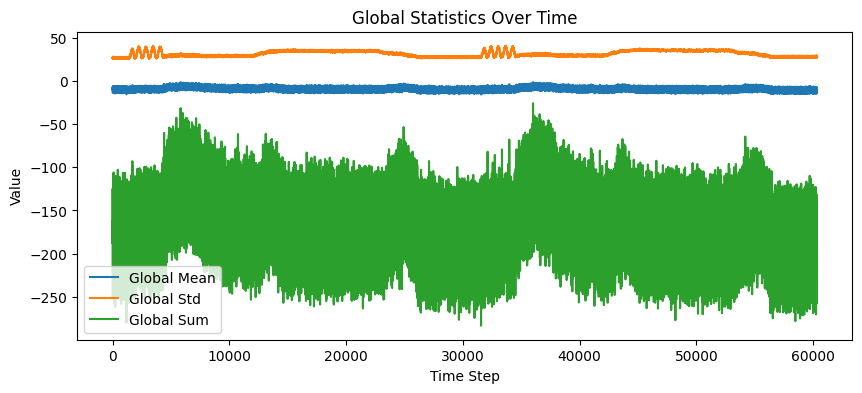

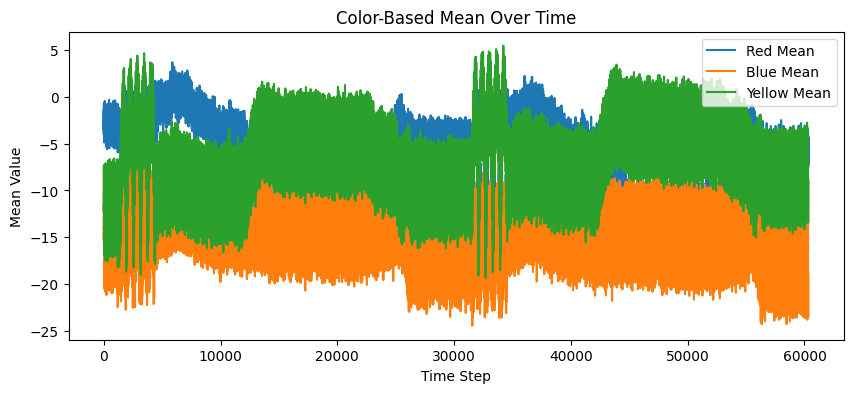

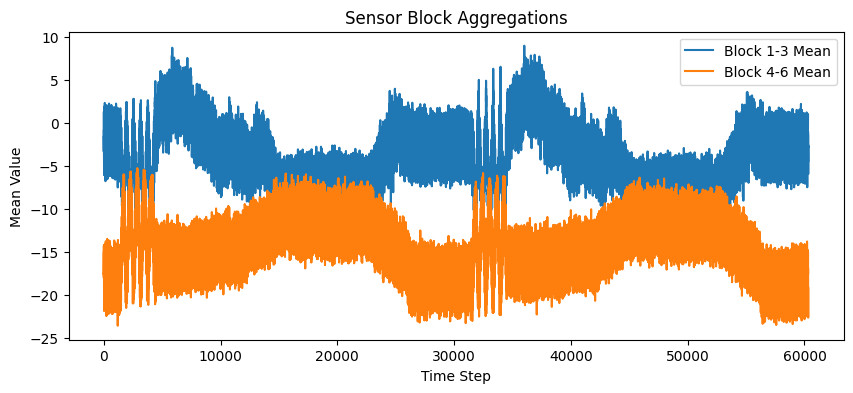

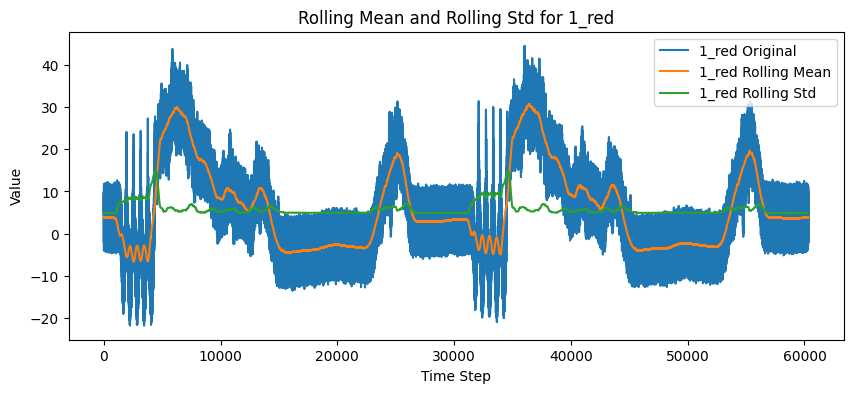

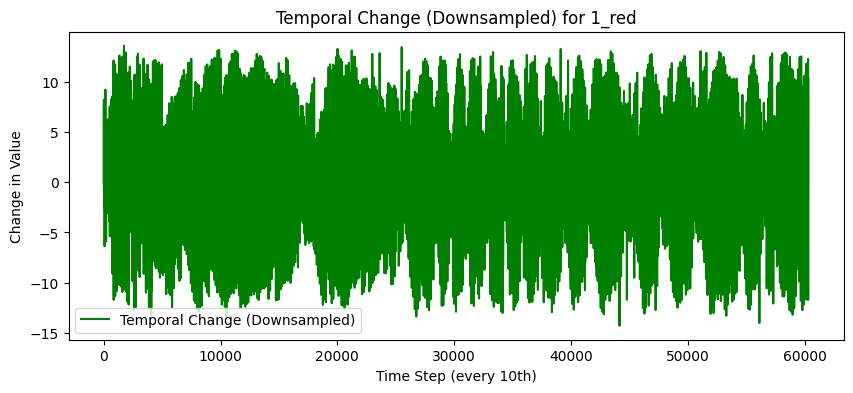

In [9]:
# Visualize some examples of the new features we generated
df_example = X_features_list[0]  

# Plot Global Stats
plt.figure(figsize=(10, 4))
plt.plot(df_example['global_mean'], label='Global Mean')
plt.plot(df_example['global_std'], label='Global Std')
plt.plot(df_example['global_sum'], label='Global Sum')
plt.title('Global Statistics Over Time')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


# Plot Color-Based Means
plt.figure(figsize=(10, 4))
plt.plot(df_example['red_color_mean'], label='Red Mean')
plt.plot(df_example['blue_color_mean'], label='Blue Mean')
plt.plot(df_example['yellow_color_mean'], label='Yellow Mean')
plt.title('Color-Based Mean Over Time')
plt.xlabel('Time Step')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Plot Sensor Block Aggregations
plt.figure(figsize=(10, 4))
plt.plot(df_example['block_1_3_mean'], label='Block 1-3 Mean')
plt.plot(df_example['block_4_6_mean'], label='Block 4-6 Mean')
plt.title('Sensor Block Aggregations')
plt.xlabel('Time Step')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Plot Rolling Mean and std
sensor_col = '1_red'

plt.figure(figsize=(10, 4))
plt.plot(df_example[sensor_col], label=f'{sensor_col} Original')
plt.plot(df_example[f'{sensor_col}_rolling_mean'], label=f'{sensor_col} Rolling Mean')
plt.plot(df_example[f'{sensor_col}_rolling_std'], label=f'{sensor_col} Rolling Std')
plt.title(f'Rolling Mean and Rolling Std for {sensor_col}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot Temporal Change (Diff) 
sensor_col = '1_red'

plt.figure(figsize=(10, 4))
plt.plot(df_example[f'{sensor_col}_diff'][::10], label='Temporal Change (Downsampled)', color='green')
plt.title(f'Temporal Change (Downsampled) for {sensor_col}')
plt.xlabel('Time Step (every 10th)')
plt.ylabel('Change in Value')
plt.legend()
plt.show()


1. Global Statistics Over Time 
- Shows overall system behavior across all sensors.

Observation:
- Global Sum shows distinct phases (possible different loading stages).
- Global Std shows localized bursts (indicating variability spikes).

2. Color-Based Mean Over Time
- Shows how red, blue, and yellow sensors behave collectively.

Observation:
- Clear separation between color groups.
- Some colors (e.g., yellow) show higher variance or sudden spikes.
- Suggests that color group behavior might carry predictive signal.

3. Sensor Block Aggregations
- Shows if different sensor groups behave differently over time.

Observation:
    - Block 1–3 exhibits higher mean stress levels compared to Block 4–6 across different stages.

4. Rolling Mean and Rolling Std Over Time
- Shows short-term trends (rolling mean) and local variability (rolling std) for a specific sensor (1_red).

Observation:
- Rolling Mean smooths out fluctuations, revealing trend cycles.
- Rolling Std highlights periods of increased or decreased variability.
- Helps identify stable vs unstable phases in the sensor signal.

5. Temporal Change (First Difference) Over Time
- Shows the rate of change in sensor readings (how much the value changes between consecutive time steps).

Observation:
- Temporal changes capture sharp transitions or sudden shifts.
- High-density signals with localized spikes may indicate events or loading changes.
- Downsampling reveals more visible patterns in the rate of change.

### Combine dataframes

In [10]:
# 1. Combine all DataFrames
X_combined = pd.concat(X_features_list, axis=0, ignore_index=True)
y_combined = pd.concat(y_aligned_list, axis=0, ignore_index=True)

### Scale features

In [11]:
# Step 1: Scale Time
time_scaled = MinMaxScaler().fit_transform(X_combined[['Time']])

# Step 2: Scale Sensor Features (1:19)
sensor_features_scaled = StandardScaler().fit_transform(X_combined.iloc[:, 1:19])

# Step 3: Scale Additional Features (20 onward)
additional_features_scaled = StandardScaler().fit_transform(X_combined.iloc[:, 19:])

# Step 4: Combine all scaled features for future modeling
X_fully_scaled = np.hstack([time_scaled, sensor_features_scaled, additional_features_scaled])

### PCA

In [12]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(np.hstack([time_scaled, sensor_features_scaled]))

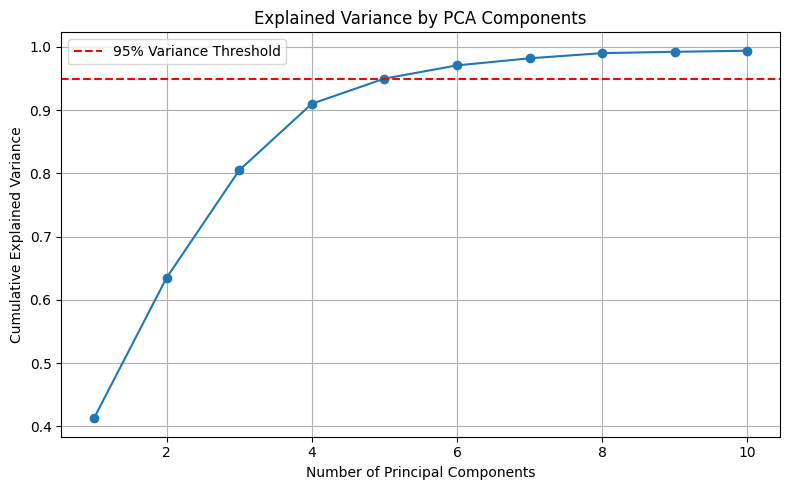

In [13]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Apply PCA and keep only the first 5 components
pca = PCA(n_components=5)
X_pca_5 = pca.fit_transform(np.hstack([time_scaled, sensor_features_scaled]))

In [15]:
# Add pca features 
X_scaled_pca = np.hstack([X_fully_scaled, X_pca_5])

In [16]:
X_scaled_pca

array([[ 0.00000000e+00, -1.15700491e-01,  1.89002870e-02, ...,
         4.10536151e+00,  1.45841705e+00, -5.48859651e-01],
       [ 6.83920752e-06, -3.38119473e-01,  8.12409280e-03, ...,
         3.99798517e+00,  1.22889159e+00, -6.66932608e-01],
       [ 1.36644289e-05, -2.47223214e-01,  1.06823954e-02, ...,
         4.38092023e+00,  1.43370964e+00, -4.12453201e-01],
       ...,
       [ 5.80403052e-01, -4.72398035e-01, -1.24387158e-02, ...,
         1.29826104e+00, -1.98418169e+00, -1.02970790e+00],
       [ 5.80409891e-01, -5.09651667e-01, -3.60069440e-02, ...,
         1.22169922e+00, -2.05983058e+00, -1.09820626e+00],
       [ 5.80416717e-01, -7.61815615e-01, -5.88288860e-02, ...,
         1.14058269e+00, -2.33142804e+00, -6.72111355e-01]])

### convert back to df

In [17]:
# names
time_feature_name = ['Time']
sensor_feature_names = X_combined.columns[1:19].tolist()

original_feature_names = time_feature_name + sensor_feature_names
additional_feature_names = X_combined.columns[19:].tolist()
pca_feature_names = [f'PCA_{i+1}' for i in range(X_pca_5.shape[1])]

# Combine all feature names
all_feature_names = original_feature_names + additional_feature_names + pca_feature_names

# Convert to DataFrame
X_features_scaled = pd.DataFrame(X_scaled_pca, columns=all_feature_names)

X_features_scaled.head()

,Time,1_red,1_blue,1_yellow,2_red,2_blue,2_yellow,3_red,3_blue,3_yellow,...,6_yellow_diff,block_1_3_mean,block_4_6_mean,block_1_3_std,block_4_6_std,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,0.000000,-0.115700,0.018900,-0.053490,0.210090,1.369550,0.794453,1.465836,1.981929,0.704586,...,-0.000034,0.692773,0.420569,-0.685229,-1.610774,1.588776,-2.046826,4.105362,1.458417,-0.548860
1,0.000007,-0.338119,0.008124,-0.054678,0.165546,1.202141,0.743621,1.414903,1.565018,0.624727,...,0.071375,0.501218,0.419857,-0.668357,-1.577446,1.546975,-2.182974,3.997985,1.228892,-0.666933
2,0.000014,-0.247223,0.010682,-0.065226,0.116420,1.571456,0.880021,1.909810,1.719939,0.674600,...,-0.560588,0.662832,0.478870,-0.754579,-1.568402,1.493051,-2.170904,4.380920,1.433710,-0.412453
3,0.000020,-0.278523,-0.004471,-0.061490,0.147287,1.464246,0.591973,1.826204,1.672087,0.711846,...,-1.096149,0.606568,0.313856,-0.720301,-1.637953,1.764442,-2.007677,4.326432,1.151091,-0.380816
4,0.000027,0.030635,0.037766,-0.038084,0.243198,1.348244,0.791912,1.595568,1.593131,0.753511,...,-0.760531,0.739073,0.445808,-0.649606,-1.656892,1.589975,-2.004037,4.324537,1.289514,-0.529336


In [18]:
### save file
joblib.dump(X_features_scaled, '../data/interim/05_X_new_features_scaled.joblib')
joblib.dump(y_combined, '../data/interim/06_y_combined.joblib')


['../data/interim/06_y_combined.joblib']

### Visualization

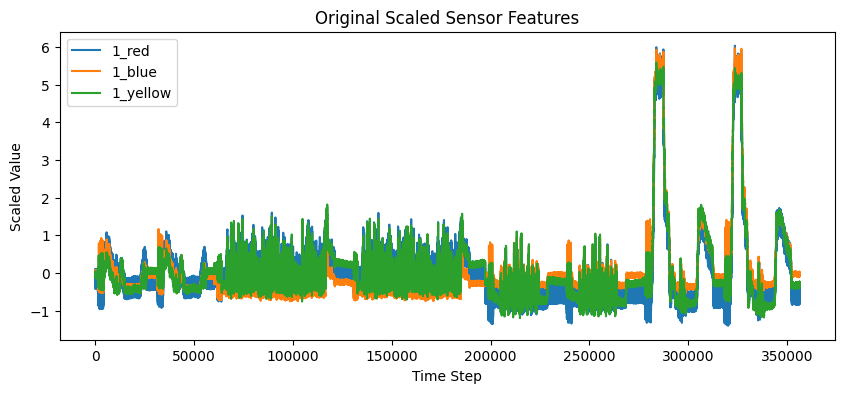

In [19]:
# plotting 3 color to see the scale

plt.figure(figsize=(10, 4))
plt.plot(X_features_scaled['1_red'], label='1_red')
plt.plot(X_features_scaled['1_blue'], label='1_blue')
plt.plot(X_features_scaled['1_yellow'], label='1_yellow')
plt.title('Original Scaled Sensor Features')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

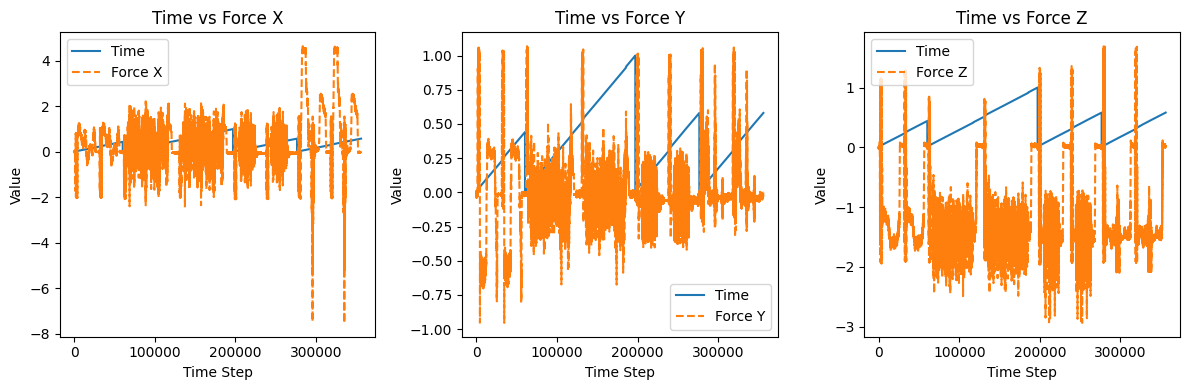

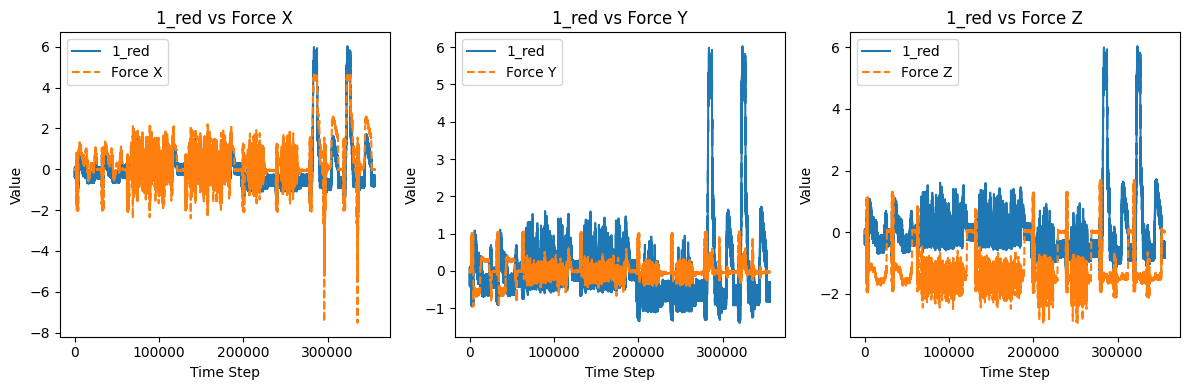

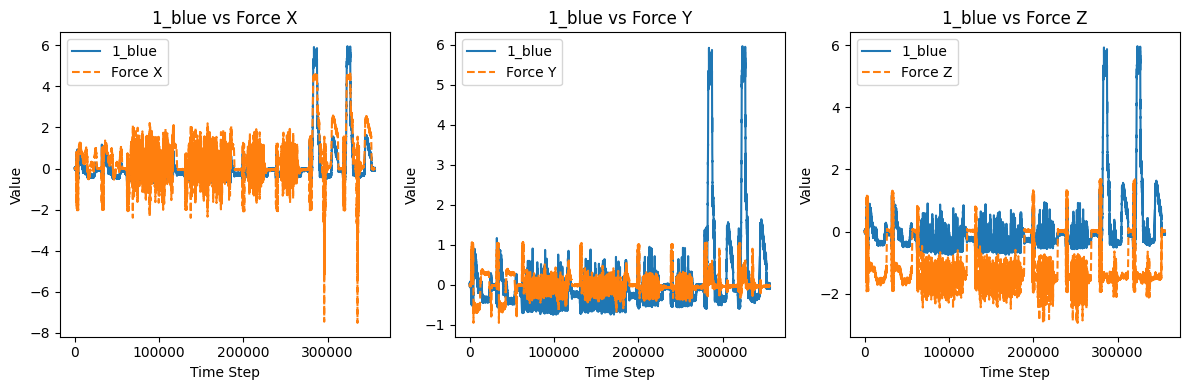

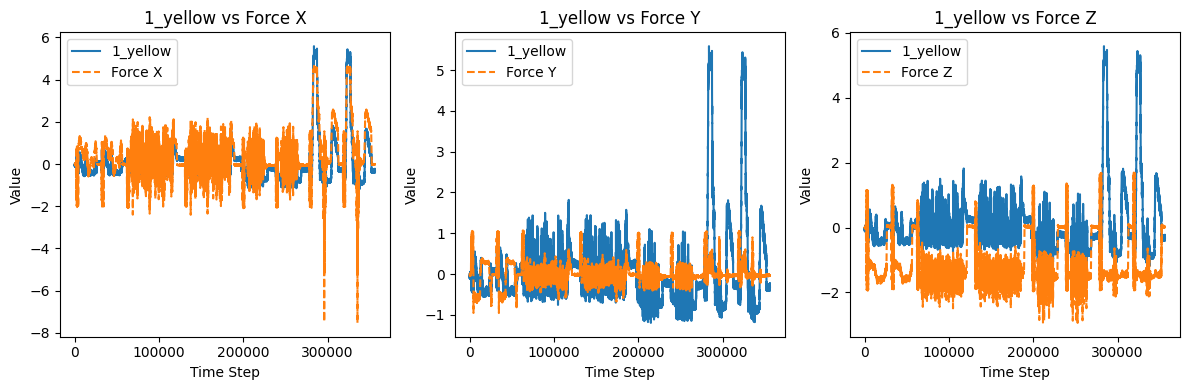

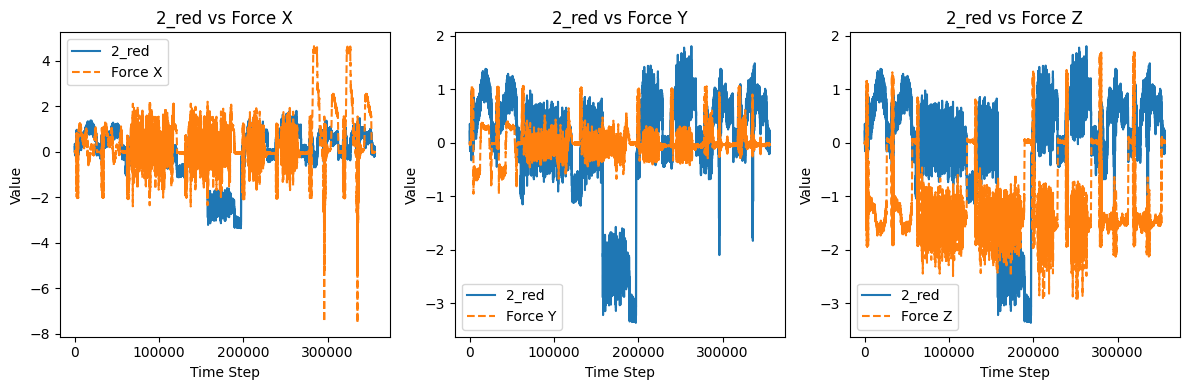

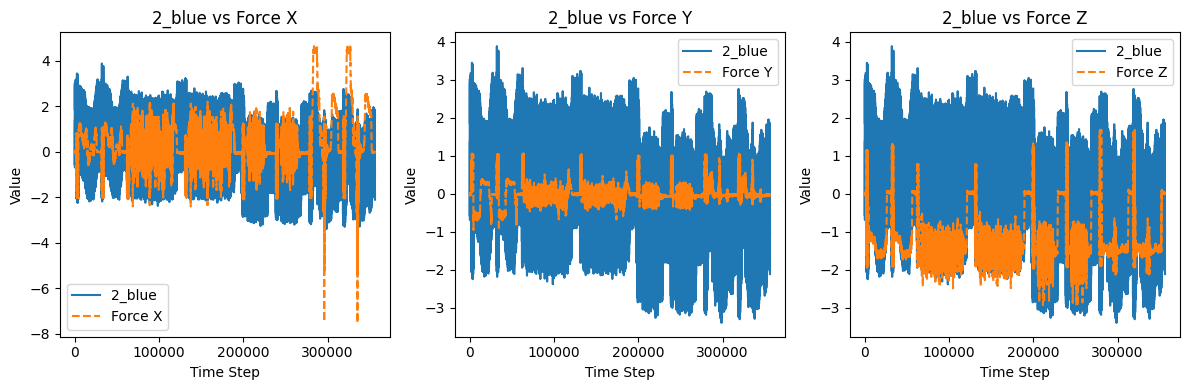

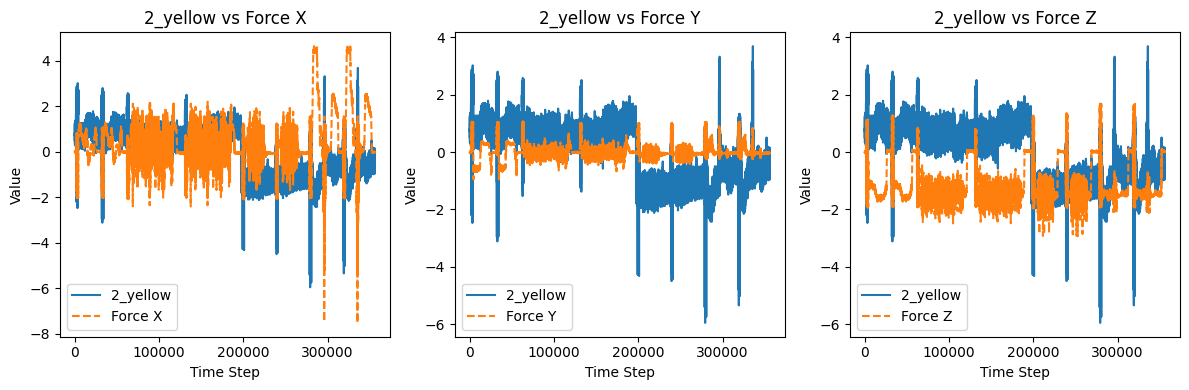

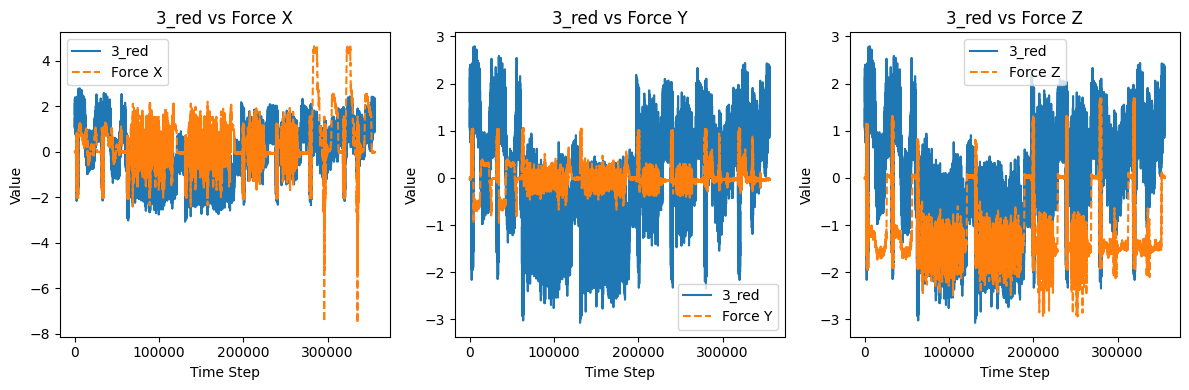

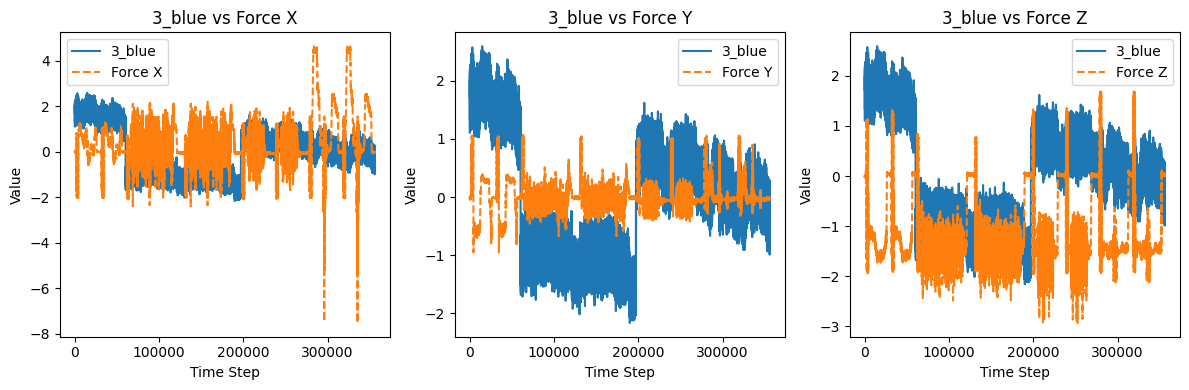

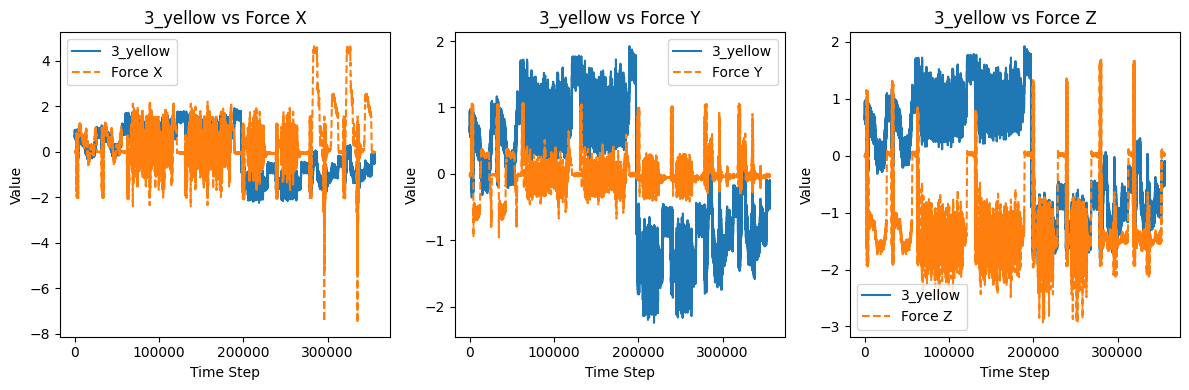

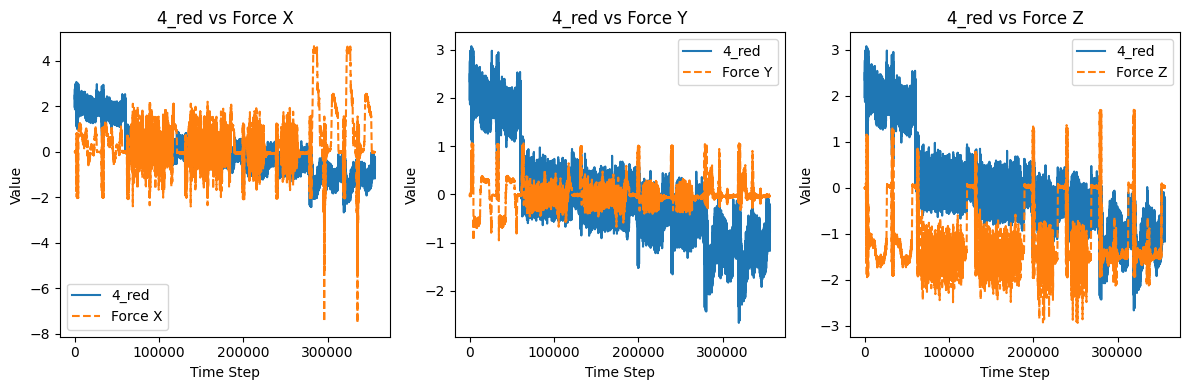

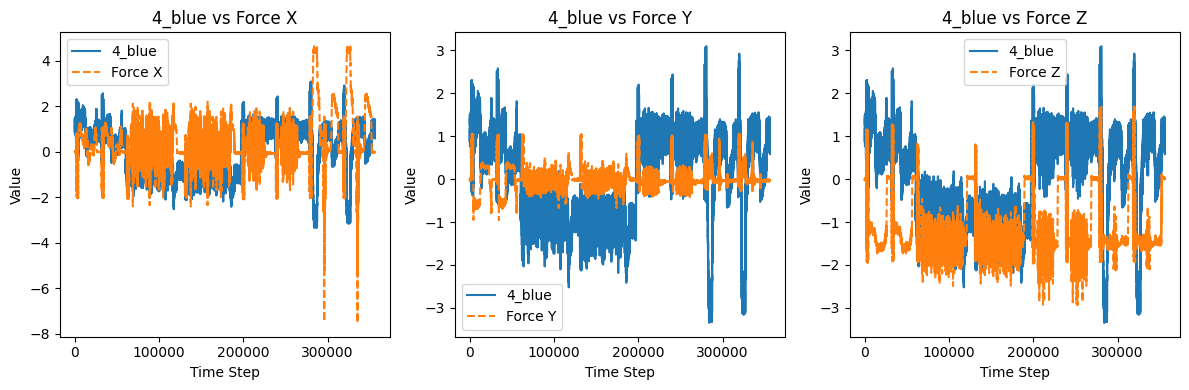

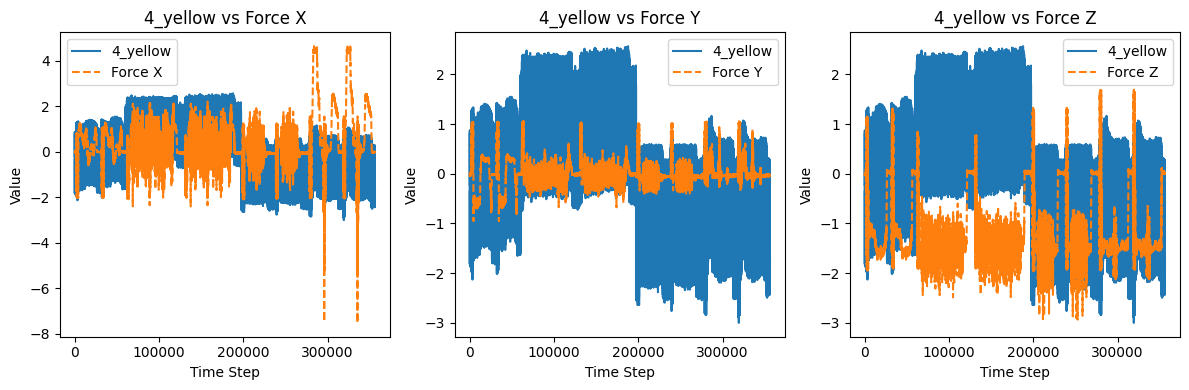

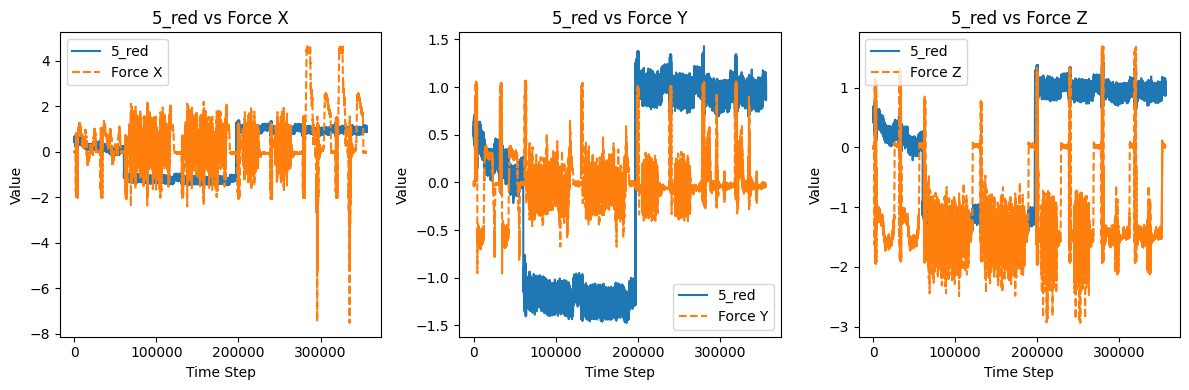

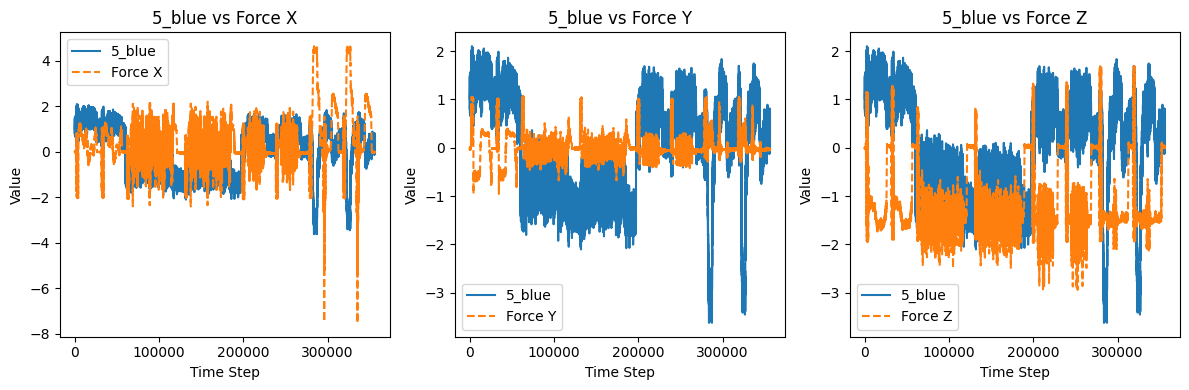

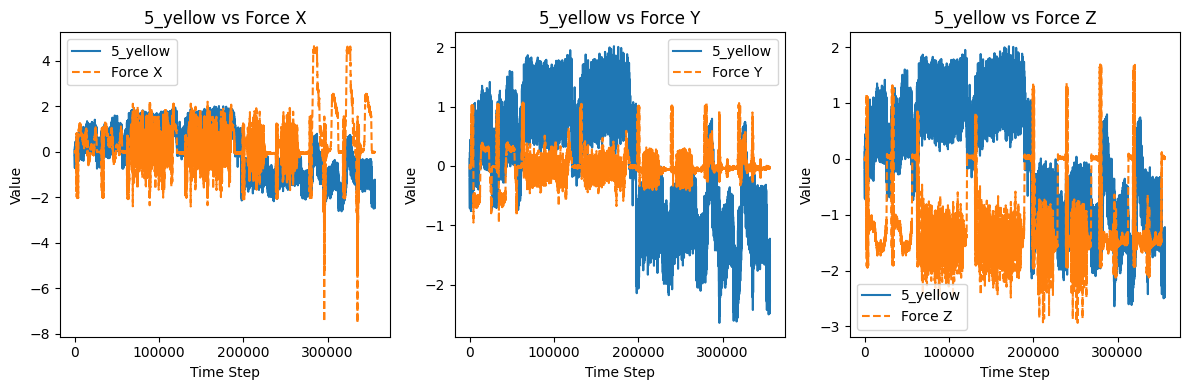

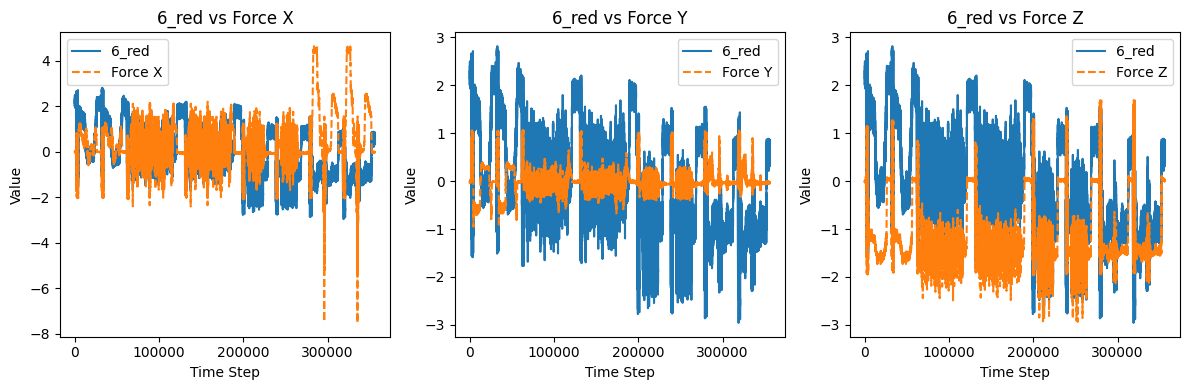

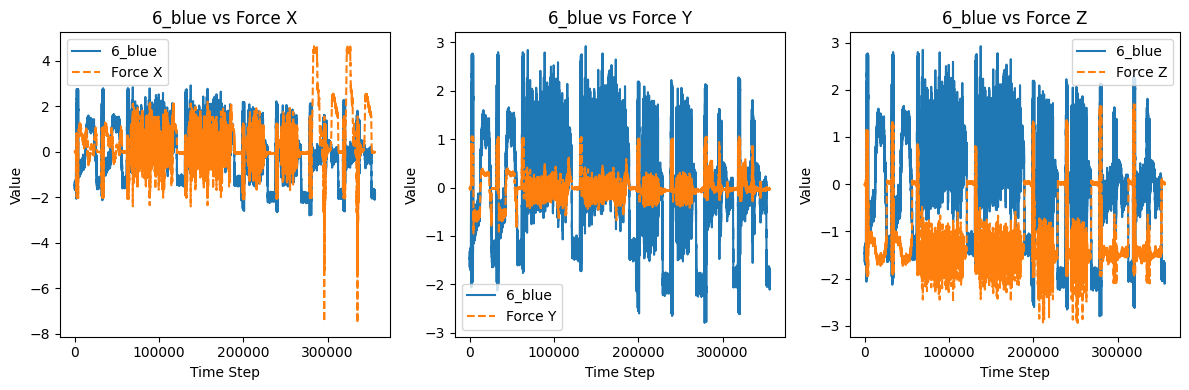

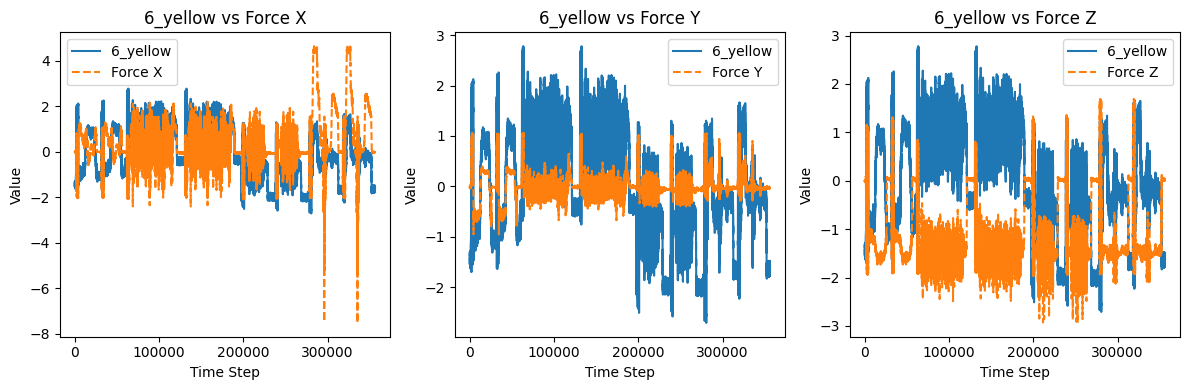

In [20]:
for feature in X_features_scaled.columns[:19]:
    plt.figure(figsize=(12, 4))

    # Plot against Force X
    plt.subplot(1, 3, 1)
    plt.plot(X_features_scaled[feature], label=f'{feature}')
    plt.plot(y_combined['X (kN)'], label='Force X', linestyle='--')
    plt.title(f'{feature} vs Force X')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

    # Plot against Force Y
    plt.subplot(1, 3, 2)
    plt.plot(X_features_scaled[feature], label=f'{feature}')
    plt.plot(y_combined['Y (kN)'], label='Force Y', linestyle='--')
    plt.title(f'{feature} vs Force Y')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

    # Plot against Force Z
    plt.subplot(1, 3, 3)
    plt.plot(X_features_scaled[feature], label=f'{feature}')
    plt.plot(y_combined['Z (kN)'], label='Force Z', linestyle='--')
    plt.title(f'{feature} vs Force Z')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

Lab 4 showed sudden negative spikes in Force X measurements not observed in the other lab sessions. Could be issues with sensor 1. 

Due to limited domain knowledge, it is unclear whether these spikes are valid physical events or measurement anomalies.